In [2]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle

# Function to save the phase diagram results to a file
def save_phase_diagram_results(phase_dict, J_values, M_values, coeff_indices, filename):
    """
    Save phase diagram results to a pickle file for later use.
    
    Args:
        phase_dict: Dictionary containing phase data
        J_values: Array of J parameter values
        M_values: Array of M parameter values
        coeff_indices: Tuple (n,m) indicating which coefficient was tracked
        filename: Name of the file to save to
    """
    data = {
        'phase_dict': phase_dict,
        'J_values': J_values,
        'M_values': M_values,
        'coeff_indices': coeff_indices
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Phase diagram data saved to {filename}")

# Function to load the phase diagram results from a file
def load_phase_diagram_results(filename):
    """
    Load phase diagram results from a pickle file.
    
    Args:
        filename: Name of the file to load from
        
    Returns:
        Dictionary containing the loaded data
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Phase diagram data loaded from {filename}")
    
    return data

# Function to extract a region of interest from the phase diagram
def extract_region(phase_dict, j_min, j_max, m_min, m_max):
    """
    Extract a specific region from the phase diagram.
    
    Args:
        phase_dict: Dictionary containing phase data
        j_min, j_max: Range of J values to include
        m_min, m_max: Range of M values to include
        
    Returns:
        Dictionary with the filtered phase data
    """
    region_dict = {}
    
    # Check if phase_dict has the expected structure
    for phase, data in phase_dict.items():
        # Skip if this phase has no data
        if not isinstance(data, dict) or "points" not in data or len(data["points"]) == 0:
            continue
            
        # Create masks for the region
        points = data["points"]
        coeffs = data["coeffs"]
        
        mask = (
            (points[:, 0] >= j_min) & 
            (points[:, 0] <= j_max) & 
            (points[:, 1] >= m_min) & 
            (points[:, 1] <= m_max)
        )
        
        # Extract points in the region
        region_points = points[mask]
        region_coeffs = coeffs[mask]
        
        if len(region_points) > 0:
            region_dict[phase] = {
                "points": region_points,
                "coeffs": region_coeffs
            }
    
    return region_dict

# Function to create reflected version of a region
def reflect_region_across_j(region_dict, coeff_indices):
    """
    Create a reflected version of the region across J=0.
    
    Args:
        region_dict: Dictionary containing region phase data
        coeff_indices: Tuple (n,m) indicating which coefficient was tracked
        
    Returns:
        Dictionary with the reflected phase data
    """
    reflected_dict = {}
    
    for phase, data in region_dict.items():
        if len(data["points"]) > 0:
            points = data["points"]
            coeffs = data["coeffs"]
            
            # Create arrays for reflected points and coefficients
            reflected_points = []
            reflected_coeffs = []
            
            # Only reflect points with J > 0
            for i, (J, M) in enumerate(points):
                if J > 0:
                    reflected_points.append([-J, M])
                    
                    # Handle coefficient reflection: for (1,0), (3,0), etc., negate coefficient
                    # For (0,0), (2,0), (0,2), etc., keep the same
                    if coeff_indices[0] % 2 == 1 and coeff_indices[1] == 0:
                        reflected_coeffs.append(-coeffs[i])  # Odd powers in J direction
                    else:
                        reflected_coeffs.append(coeffs[i])  # Even powers
            
            # Store reflected data if there are any points
            if reflected_points:
                # Special case: A_Phase reflections should be stored as C_Phase
                if phase == "A_Phase":
                    target_phase = "C_Phase"
                else:
                    target_phase = phase
                
                # Initialize the phase if not already present
                if target_phase not in reflected_dict:
                    reflected_dict[target_phase] = {
                        "points": [],
                        "coeffs": []
                    }
                
                # Add to existing reflected phase points and coefficients
                existing_points = reflected_dict[target_phase]["points"]
                existing_coeffs = reflected_dict[target_phase]["coeffs"]
                
                reflected_dict[target_phase]["points"] = np.array(
                    existing_points + reflected_points if isinstance(existing_points, list) 
                    else np.vstack([existing_points, reflected_points])
                )
                reflected_dict[target_phase]["coeffs"] = np.array(
                    existing_coeffs + reflected_coeffs if isinstance(existing_coeffs, list)
                    else np.append(existing_coeffs, reflected_coeffs)
                )
    
    return reflected_dict

def prepare_data_for_plotting(region_dict, reflected_dict, j_min, j_max, m_min, m_max, coeff_indices):
    """
    Organize region and reflected data into a format compatible with plot_phase_diagram_with_coeffs.
    
    Args:
        region_dict: Dictionary containing region phase data
        reflected_dict: Dictionary containing reflected phase data
        j_min, j_max: Range of J values 
        m_min, m_max: Range of M values
        coeff_indices: Tuple (n,m) indicating which coefficient was tracked
        
    Returns:
        Tuple (J_values, M_values, combined_dict, coeff_indices)
    """
    # Create parameter arrays from the region boundaries
    J_values = np.linspace(j_min, j_max, 100)
    M_values = np.linspace(m_min, m_max, 100)
    
    # Create a combined dictionary with both original and reflected points
    combined_dict = {}
    
    # First add all region points
    for phase, data in region_dict.items():
        if phase not in combined_dict:
            combined_dict[phase] = {"points": [], "coeffs": []}
        
        if len(data["points"]) > 0:
            # If combined_dict[phase]["points"] is empty, initialize directly
            if not combined_dict[phase]["points"]:
                combined_dict[phase]["points"] = data["points"]
                combined_dict[phase]["coeffs"] = data["coeffs"]
            else:
                # Otherwise append to existing data
                combined_dict[phase]["points"] = np.vstack([combined_dict[phase]["points"], data["points"]])
                combined_dict[phase]["coeffs"] = np.append(combined_dict[phase]["coeffs"], data["coeffs"])
    
    # Then add reflected points
    for phase, data in reflected_dict.items():
        if phase not in combined_dict:
            combined_dict[phase] = {"points": [], "coeffs": []}
        
        if len(data["points"]) > 0:
            # If combined_dict[phase]["points"] is empty, initialize directly
            if not isinstance(combined_dict[phase]["points"], np.ndarray) or len(combined_dict[phase]["points"]) == 0:
                combined_dict[phase]["points"] = data["points"]
                combined_dict[phase]["coeffs"] = data["coeffs"]
            else:
                # Otherwise append to existing data
                combined_dict[phase]["points"] = np.vstack([combined_dict[phase]["points"], data["points"]])
                combined_dict[phase]["coeffs"] = np.append(combined_dict[phase]["coeffs"], data["coeffs"])
    
    return J_values, M_values, combined_dict, coeff_indices

In [30]:
def plot_phase_diagram_with_coeffs(J_values, M_values, phase_dict, coeff_indices=(1, 0), 
                                  show_colorbars=True, path=None, marker_size=None):
    """
    Plot phase diagram with coefficient values represented by color gradients within each phase.
    
    Args:
        J_values: Array of J parameter values
        M_values: Array of M parameter values
        phase_dict: Dictionary of phase data including points and coefficient values
        coeff_indices: Tuple (n,m) indicating which coefficient is being visualized
        show_colorbars: Whether to show colorbars for coefficient values
        path: Optional path to save the figure
    
    Returns:
        Matplotlib figure
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize, LinearSegmentedColormap
    import matplotlib.cm as cm
    from matplotlib.gridspec import GridSpec
    
    # Define phases that will use color gradients
    gradient_phases = ["A_Phase", "B_Phase", "C_Phase", "E_Phase"]
                        # 'F'    r'F$_\sigma$'  'A'   r'A$_\sigma$'
    
    # Define a custom order for plotting colorbars
    colorbar_order = ["B_Phase", "E_Phase", "A_Phase", "C_Phase"]  # Desired order
    
    # Also rearrange the colormap phase names to match the new order
    colormap_phase_names = [r'F$_\sigma$', r'A$_\sigma$', 'F', 'A']  # Reordered to match colorbar_order


    # Create figure with grid layout for main plot and colorbars
    if show_colorbars:
        fig = plt.figure(figsize=(7.5, 8.5), dpi=100)
        gs = GridSpec(len(gradient_phases) + 2, 1,
                      height_ratios=[6, .7] + [0.2] * len(gradient_phases),
                      hspace=0)
        ax = fig.add_subplot(gs[0])
    else:
        fig = plt.figure(figsize=(8, 8), dpi=150)
        ax = fig.add_subplot(111)
    
    fig.set_facecolor("white")
    plt.rc(group="font", family="Arial", weight="bold", size=14)
    plt.rc(group="lines", linewidth=1)
    plt.rc(group="axes", linewidth=2)
    
    # Base colors for each phase
    base_colors = {
        "D_Phase": "white",
        "A_Phase": "blue",
        "B_Phase": "green",
        "C_Phase": "red",
        "E_Phase": "orange",
        "X_Phase": "black",
        "U_Phase": "yellow"
    }
    
    # Create custom colormaps from light to dense colors (not white)
    custom_colormaps = {
        "A_Phase": LinearSegmentedColormap.from_list("Blues_custom", ["#BBDEFB", "#0D47A1"]),  # Light blue to dark blue
        "B_Phase": LinearSegmentedColormap.from_list("Greens_custom", ["#C8E6C9", "#1B5E20"]),  # Light green to dark green
        "C_Phase": LinearSegmentedColormap.from_list("Reds_custom", ["#FFCDD2", "#B71C1C"]),  # Light red to dark red
        "E_Phase": LinearSegmentedColormap.from_list("Oranges_custom", ["#FFE0B2", "#E65100"])  # Light orange to dark orange
    }
    
    # Define legend handles for each phase
    legend_handles = []
    legend_labels = []
    
    # Store colorbar metadata for later creation
    colorbar_data = {}
    
    # Plot each phase
    for phase, data in phase_dict.items():
        points = data["points"]
        coeffs = data["coeffs"]
        
        if len(points) > 0:
            # Add a representative handle for the legend
            legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', 
                                           markerfacecolor=base_colors[phase], markersize=10))
            legend_labels.append(phase)

            if marker_size:
                ms = marker_size
            # Only use color gradients for specified phases
            if phase in gradient_phases and len(points) > 1 and len(np.unique(coeffs)) > 1:
                # Create color array based on coefficient values
                norm = Normalize(vmin=np.min(coeffs), vmax=np.max(coeffs))
                colors = custom_colormaps[phase](norm(coeffs))

                # Store colorbar data for later
                if show_colorbars:
                    colorbar_data[phase] = {
                        'cmap': custom_colormaps[phase],
                        'norm': norm,
                        'vmin': np.min(coeffs),
                        'vmax': np.max(coeffs)}
                
                # Scatter plot with color gradient
                ax.scatter(points[:, 1], points[:, 0], c=colors, 
                         marker='s', s=ms, edgecolor='none', alpha=1)
            else:
                # Use a solid color for other phases
                ax.scatter(points[:, 1], points[:, 0], c=base_colors[phase], 
                         marker='s', s=ms, edgecolor='none', alpha=1)
    
    # Add legend for phases
    #ax.legend(legend_handles, legend_labels, loc='upper right', title="Phases")
    
    # Set labels and styling for main plot
    #ax.set_xlabel("Four-Spin Interaction M", fontsize=14)
    #ax.set_ylabel("Two-Spin Interaction J", fontsize=14)
    #ax.set_title(f"Phase Diagram with λ({coeff_indices[0]},{coeff_indices[1]}) Values", fontsize=16)
    ax.tick_params(axis="both", direction="in", width=2, length=4)

    x_min, x_max = min(M_values), max(M_values)
    y_min, y_max = -0.4, 0.4 #min(J_values), max(J_values)

    # Set axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_ylim(-.5, .5)

    # For J=M line
    line_min = max(x_min, y_min)
    line_max = 0
    # For J=-M line
    neg_line_min = max(x_min, y_min)
    neg_line_max = 0
    
    # Add dashed line for J=M
    ax.plot([line_min, line_max], [line_min, line_max], 'k--', linewidth=1.5, zorder=3)
    # Add dashed line for J=-M
    ax.plot([neg_line_min, neg_line_max], [-neg_line_min, -neg_line_max], 'k--', linewidth=1.5, zorder=3)

    # Add colorbars under the main plot
    if show_colorbars:

        # First determine the global min and max across all gradients to create a consistent range
        global_vmin = float('inf')
        global_vmax = float('-inf')
        for phase in gradient_phases:
            if phase in colorbar_data:
                global_vmin = min(global_vmin, colorbar_data[phase]['vmin'])
                global_vmax = max(global_vmax, colorbar_data[phase]['vmax'])
        
        # Create a global norm
        global_norm = Normalize(vmin=global_vmin, vmax=global_vmax)

        # Only create colorbars for phases that actually exist in the diagram
        i = 0
        for phase in colorbar_order:  # Use colorbar_order instead of gradient_phases
            if phase in colorbar_data:
                # Create a horizontal colorbar below the main plot
                cbar_ax = fig.add_subplot(gs[i+2])

                # Update to use global norm instead of individual norms
                cb_data = colorbar_data[phase]
                sm = cm.ScalarMappable(cmap=cb_data['cmap'], norm=global_norm)
                sm.set_array([])
                
                # Make colorbar horizontal and thin without label
                cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')

                # Make ticks thicker and point inward
                cbar.ax.tick_params(width=2, direction='in', length=4, top=True, bottom=True)

                # Show ticks on all colorbars, but only show labels on the bottom one
                if i < len([p for p in gradient_phases if p in colorbar_data]) - 1:  # Not the last/bottom colorbar
                    cbar.ax.set_xticklabels([])  # Hide labels but keep ticks
                else:  # Last/bottom colorbar
                    cbar.ax.tick_params(labelsize=12)
                
                # Add only a small phase indicator text at the beginning of the colorbar
                cbar_ax.text(-0.05, 0.5, colormap_phase_names[i], #phase.split('_')[0], 
                            transform=cbar_ax.transAxes, 
                            verticalalignment='center',
                            fontsize=14, fontweight='bold')
                
                i += 1
    
    plt.tight_layout()
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    
    return fig

In [32]:
# Load your data
data = load_phase_diagram_results("data/phase_diagram_coeff_312_half.pkl")
phase_dict = data['phase_dict']
J_values_full = data['J_values']
M_values_full = data['M_values']
coeff_indices = data['coeff_indices']

# Extract region of interest
j_min, j_max = 0.0, .4  # Range of J values
m_min, m_max = -3, 3  # Range of M values
region_dict = extract_region(phase_dict, j_min, j_max, m_min, m_max)

# Create reflected version
reflected_dict = reflect_region_across_j(region_dict, coeff_indices)

# Prepare data for plotting function
J_values, M_values, combined_dict, coeff_indices = prepare_data_for_plotting(
    region_dict, reflected_dict, j_min, j_max, m_min, m_max, coeff_indices)

Phase diagram data loaded from data/phase_diagram_coeff_312_half.pkl


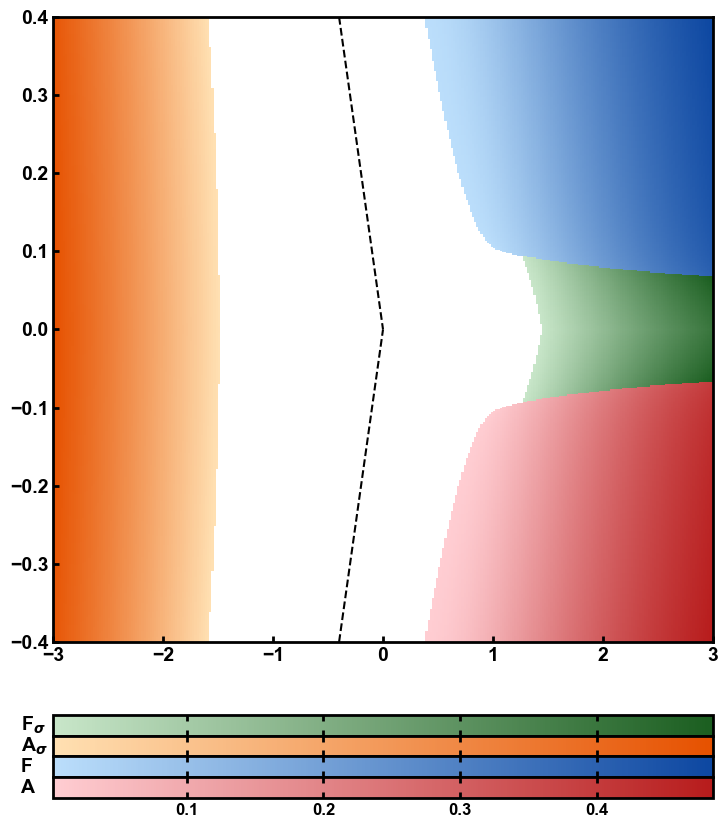

In [38]:
# Plot using the existing function
fig = plot_phase_diagram_with_coeffs(
    J_values=J_values,
    M_values=M_values,
    phase_dict=combined_dict,
    coeff_indices=coeff_indices,
    show_colorbars=True,
    path="phase_diagram_with_coeff(2,2).png",
    marker_size=2.4,)
plt.show()